In [7]:
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import decoupler as dc

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
BREAST_CANCER_DATASET = "V1_Breast_Cancer_Block_A_Section_1"
LYMPH_NODE_DATASET = "V1_Human_Lymph_Node"

# Download and process breast cancer dataset

Data preprocessing

In [8]:
adata = sc.datasets.visium_sge(sample_id=BREAST_CANCER_DATASET)
adata.var_names_make_unique()

# Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

# Annotate the group of mitochondrial genes as 'mt'
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
# Filter cells following standard QC criteria.
adata = adata[adata.obs.pct_counts_mt < 5, :]

# Normalize the data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.layers['log_norm'] = adata.X.copy()

/opt/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [9]:
adata

AnnData object with n_obs × n_vars = 3001 × 22240
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'spatial', 'log1p'
    obsm: 'spatial'
    layers: 'log_norm'

/var/folders/4j/6zqpz1_95sg38nr0mn2rh1lh0000gn/T/ipykernel_17839/1971717914.py:21: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


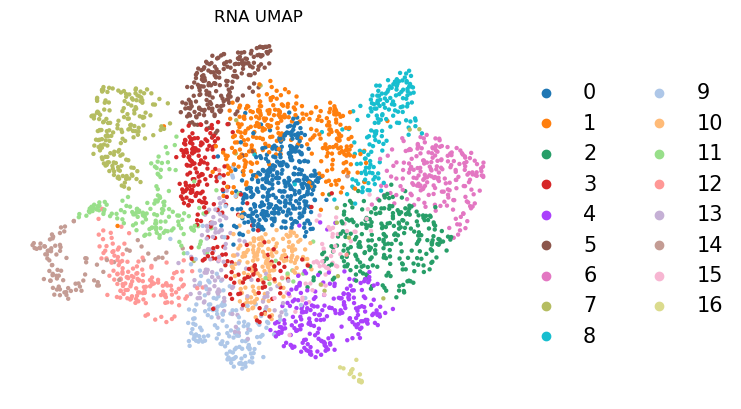

In [10]:
# Identify the highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# Regress and scale the data
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

# Generate PCA features
sc.tl.pca(adata, svd_solver='arpack')

# Restore X to be norm counts
dc.swap_layer(adata, 'log_norm', X_layer_key=None, inplace=True)

# Compute distances in the PCA space, and find cell neighbors
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

# Generate UMAP features
sc.tl.umap(adata)

# Run leiden clustering algorithm
sc.tl.leiden(adata)

# Visualize
sc.pl.umap(adata, color='leiden', title='RNA UMAP',
           frameon=False, legend_fontweight='normal', legend_fontsize=15)

In [11]:
adata.obs_names = adata.obs_names.str.replace("-", ".")
adata._inplace_subset_obs(adata.obs_names)
adata.obs_names

Index(['AAACAAGTATCTCCCA.1', 'AAACACCAATAACTGC.1', 'AAACAGAGCGACTCCT.1',
       'AAACAGGGTCTATATT.1', 'AAACAGTGTTCCTGGG.1', 'AAACATTTCCCGGATT.1',
       'AAACCCGAACGAAATC.1', 'AAACCGGGTAGGTACC.1', 'AAACCTCATGAAGTTG.1',
       'AAACGAGACGGTTGAT.1',
       ...
       'TTGTGCAGCCACGTCA.1', 'TTGTGGCCCTGACAGT.1', 'TTGTGGTAGGAGGGAT.1',
       'TTGTGGTGGTACTAAG.1', 'TTGTGTATGCCACCAA.1', 'TTGTTAGCAAATTCGA.1',
       'TTGTTGTGTGTCAAGA.1', 'TTGTTTCACATCCAGG.1', 'TTGTTTCATTAGTCTA.1',
       'TTGTTTCCATACAACT.1'],
      dtype='object', length=3001)

In [13]:
adata.obs['leiden'].to_csv(f'data/{BREAST_CANCER_DATASET}/metadata.tsv', sep = '\t', index_label="barcode_sample")

In [14]:
adata.write_h5ad(f'data/{BREAST_CANCER_DATASET}/breast_cancer.h5ad')

Compute CPDB scores

In [15]:
cpdb_file_path = '/Users/aakash/cellphonedb/db/v5.0.0/cellphonedb.zip'
meta_file_path = f'data/{BREAST_CANCER_DATASET}/metadata.tsv'
counts_file_path = f'data/{BREAST_CANCER_DATASET}/breast_cancer.h5ad'
out_path = f'data/{BREAST_CANCER_DATASET}/cpdb_scores/'

In [16]:
from cellphonedb.src.core.methods import cpdb_analysis_method

cpdb_results = cpdb_analysis_method.call(
    cpdb_file_path = cpdb_file_path,           # mandatory: CellphoneDB database zip file.
    meta_file_path = meta_file_path,           # mandatory: tsv file defining barcodes to cell label.
    counts_file_path = counts_file_path,       # mandatory: normalized count matrix - a path to the counts file, or an in-memory AnnData object
    counts_data = 'hgnc_symbol',               # defines the gene annotation in counts matrix.
    score_interactions = True,                 # optional: whether to score interactions or not. 
    output_path = out_path,                    # Path to save results    microenvs_file_path = None,
    separator = '|',                           # Sets the string to employ to separate cells in the results dataframes "cellA|CellB".
    threads = 5,                               # number of threads to use in the analysis.
    threshold = 0.1,                           # defines the min % of cells expressing a gene for this to be employed in the analysis.
    result_precision = 3,                      # Sets the rounding for the mean values in significan_means.
    debug = False,                             # Saves all intermediate tables emplyed during the analysis in pkl format.
    output_suffix = None                       # Replaces the timestamp in the output files by a user defined string in the  (default: None)
)

[ ][CORE][13/12/24-01:29:45][INFO] [Non Statistical Method] Threshold:0.1 Precision:3
Reading user files...
The following user files were loaded successfully:
data/V1_Breast_Cancer_Block_A_Section_1/breast_cancer.h5ad
data/V1_Breast_Cancer_Block_A_Section_1/metadata.tsv
[ ][CORE][13/12/24-01:29:47][INFO] Running Basic Analysis
[ ][CORE][13/12/24-01:29:47][INFO] Building results
[ ][CORE][13/12/24-01:29:47][INFO] Scoring interactions: Filtering genes per cell type..


100%|██████████| 17/17 [00:00<00:00, 428.57it/s]

[ ][CORE][13/12/24-01:29:47][INFO] Scoring interactions: Calculating mean expression of each gene per group/cell type..



100%|██████████| 17/17 [00:00<00:00, 1144.00it/s]
/opt/anaconda3/lib/python3.11/site-packages/cellphonedb/utils/scoring_utils.py:138: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  matrix[index_name].replace(to_replace=id2name, inplace=True)


[ ][CORE][13/12/24-01:29:47][INFO] Scoring interactions: Calculating scores for all interactions and cell types..


100%|██████████| 289/289 [00:29<00:00,  9.90it/s]


Saved means_result to V1_Breast_Cancer_Block_A_Section_1/cpdb_scores/simple_analysis_means_result_12_13_2024_013017.txt
Saved deconvoluted to V1_Breast_Cancer_Block_A_Section_1/cpdb_scores/simple_analysis_deconvoluted_12_13_2024_013017.txt
Saved deconvoluted_percents to V1_Breast_Cancer_Block_A_Section_1/cpdb_scores/simple_analysis_deconvoluted_percents_12_13_2024_013017.txt
Saved interaction_scores to V1_Breast_Cancer_Block_A_Section_1/cpdb_scores/simple_analysis_interaction_scores_12_13_2024_013017.txt


In [17]:
interaction_scores = cpdb_results["interaction_scores"]
interaction_scores.head(3)

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,...,9|15,9|16,9|2,9|3,9|4,9|5,9|6,9|7,9|8,9|9
0,CPI-SC0A2DB962D,CDH1_integrin_a2b1_complex,simple:P12830,complex:integrin_a2b1_complex,CDH1,NaN,False,False,False,curated,...,22.569,0.0,4.987,9.729,1.882,11.936,9.829,13.327,8.616,19.442
1,CPI-SC0B5CEA47D,COL10A1_integrin_a2b1_complex,simple:Q03692,complex:integrin_a2b1_complex,COL10A1,NaN,True,False,False,curated,...,20.709,0.0,4.576,8.927,1.727,10.952,9.019,12.229,7.907,17.841
2,CPI-SC0C8B7BCBB,COL11A1_integrin_a2b1_complex,simple:P12107,complex:integrin_a2b1_complex,COL11A1,NaN,True,False,False,curated,...,33.116,0.0,7.318,14.275,2.761,17.514,14.422,19.555,12.643,28.529


In [18]:
import re
interaction_columns = [col for col in interaction_scores.columns if re.match(r'^\d+\|\d+$', col)]
average_interactions = interaction_scores[interaction_columns].mean(axis=0)
average_interactions

0|0     5.941880
0|1     0.876900
0|10    6.668330
0|11    5.352286
0|12    5.467238
          ...   
9|5     5.202550
9|6     5.027332
9|7     5.066826
9|8     5.074300
9|9     8.662223
Length: 289, dtype: float64

In [20]:
# Create empty matrix to store scores
n_cell_types = len(set(adata.obs["leiden"]))
interaction_matrix = np.zeros((n_cell_types, n_cell_types))

# Fill matrix with scores
for idx, score in average_interactions.items():
    i, j = map(int, idx.split("|"))
    interaction_matrix[i, j] = score

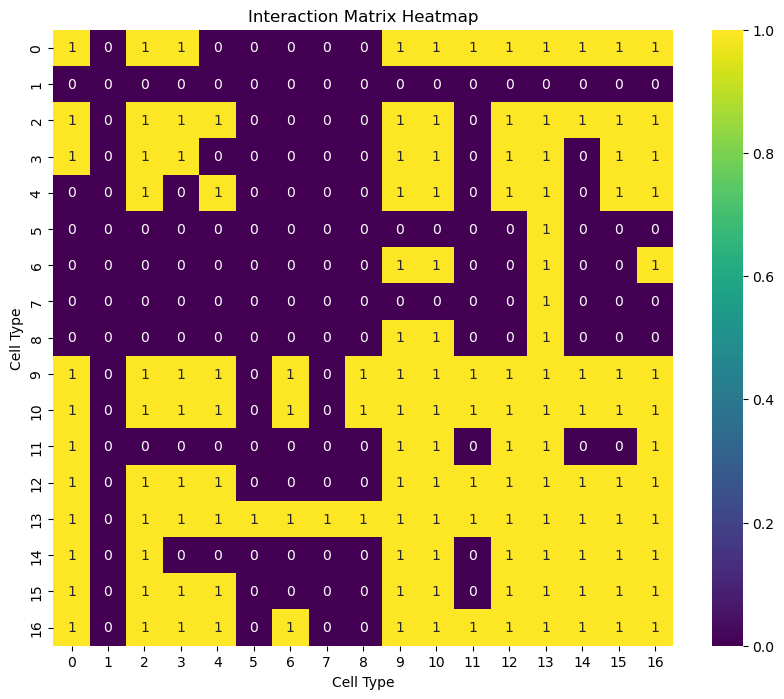

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt


symmetric = ((interaction_matrix + interaction_matrix.T) / 2)
thresholded = symmetric > np.median(symmetric)


plt.figure(figsize=(10, 8))
sns.heatmap(thresholded, annot=True, cmap="viridis", cbar=True)
plt.title("Interaction Matrix Heatmap")
plt.xlabel("Cell Type")
plt.ylabel("Cell Type")
plt.show()

In [22]:
interaction_scores.to_csv(f"data/{BREAST_CANCER_DATASET}/cpdb_scores/interaction_scores.tsv", sep = '\t')
pd.DataFrame(thresholded).to_csv(f"data/{BREAST_CANCER_DATASET}/cpdb_scores/thresholded_interaction_matrix.tsv", sep = '\t')

# Download and process lymph node dataset

Data preprocessing

In [23]:
adata = sc.datasets.visium_sge(sample_id=LYMPH_NODE_DATASET)
adata.var_names_make_unique()

# Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

# Annotate the group of mitochondrial genes as 'mt'
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
# Filter cells following standard QC criteria.
adata = adata[adata.obs.pct_counts_mt < 5, :]

# Normalize the data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.layers['log_norm'] = adata.X.copy()

  0%|          | 0.00/7.86M [00:00<?, ?B/s]

  0%|          | 0.00/29.3M [00:00<?, ?B/s]

In [24]:
adata

AnnData object with n_obs × n_vars = 4022 × 22411
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'spatial', 'log1p'
    obsm: 'spatial'
    layers: 'log_norm'

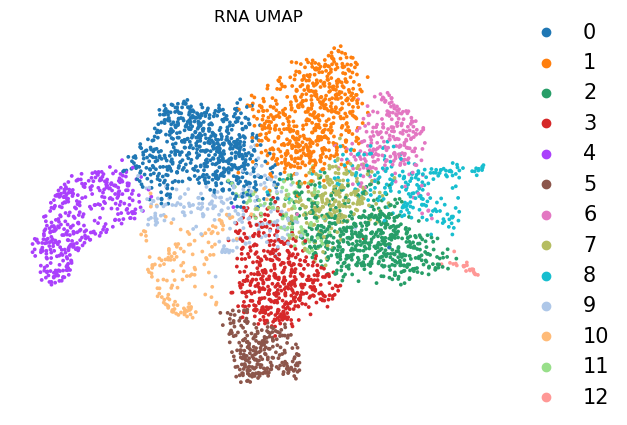

In [25]:
# Identify the highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# Regress and scale the data
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

# Generate PCA features
sc.tl.pca(adata, svd_solver='arpack')

# Restore X to be norm counts
dc.swap_layer(adata, 'log_norm', X_layer_key=None, inplace=True)

# Compute distances in the PCA space, and find cell neighbors
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

# Generate UMAP features
sc.tl.umap(adata)

# Run leiden clustering algorithm
sc.tl.leiden(adata)

# Visualize
sc.pl.umap(adata, color='leiden', title='RNA UMAP',
           frameon=False, legend_fontweight='normal', legend_fontsize=15)

In [26]:
adata.obs_names = adata.obs_names.str.replace("-", ".")
adata._inplace_subset_obs(adata.obs_names)
adata.obs_names

Index(['AAACAAGTATCTCCCA.1', 'AAACAATCTACTAGCA.1', 'AAACACCAATAACTGC.1',
       'AAACAGAGCGACTCCT.1', 'AAACAGCTTTCAGAAG.1', 'AAACAGGGTCTATATT.1',
       'AAACAGTGTTCCTGGG.1', 'AAACATTTCCCGGATT.1', 'AAACCCGAACGAAATC.1',
       'AAACCGGGTAGGTACC.1',
       ...
       'TTGTGTTTCCCGAAAG.1', 'TTGTTAGCAAATTCGA.1', 'TTGTTCAGTGTGCTAC.1',
       'TTGTTGGCAATGACTG.1', 'TTGTTGTGTGTCAAGA.1', 'TTGTTTCACATCCAGG.1',
       'TTGTTTCATTAGTCTA.1', 'TTGTTTCCATACAACT.1', 'TTGTTTGTATTACACG.1',
       'TTGTTTGTGTAAATTC.1'],
      dtype='object', length=4022)

In [27]:
adata.obs['leiden'].to_csv(f'data/{LYMPH_NODE_DATASET}/metadata.tsv', sep = '\t', index_label="barcode_sample")
adata.write_h5ad(f'data/{LYMPH_NODE_DATASET}/lymph_node.h5ad')

Compute CPDB scores

In [28]:
cpdb_file_path = '/Users/aakash/cellphonedb/db/v5.0.0/cellphonedb.zip'
meta_file_path = f'data/{LYMPH_NODE_DATASET}/metadata.tsv'
counts_file_path = f'data/{LYMPH_NODE_DATASET}/lymph_node.h5ad'
out_path = f'data/{LYMPH_NODE_DATASET}/cpdb_scores/'

In [29]:
cpdb_results = cpdb_analysis_method.call(
    cpdb_file_path = cpdb_file_path,           # mandatory: CellphoneDB database zip file.
    meta_file_path = meta_file_path,           # mandatory: tsv file defining barcodes to cell label.
    counts_file_path = counts_file_path,       # mandatory: normalized count matrix - a path to the counts file, or an in-memory AnnData object
    counts_data = 'hgnc_symbol',               # defines the gene annotation in counts matrix.
    score_interactions = True,                 # optional: whether to score interactions or not. 
    output_path = out_path,                    # Path to save results    microenvs_file_path = None,
    separator = '|',                           # Sets the string to employ to separate cells in the results dataframes "cellA|CellB".
    threads = 5,                               # number of threads to use in the analysis.
    threshold = 0.1,                           # defines the min % of cells expressing a gene for this to be employed in the analysis.
    result_precision = 3,                      # Sets the rounding for the mean values in significan_means.
    debug = False,                             # Saves all intermediate tables emplyed during the analysis in pkl format.
    output_suffix = None                       # Replaces the timestamp in the output files by a user defined string in the  (default: None)
)

[ ][CORE][13/12/24-01:37:20][INFO] [Non Statistical Method] Threshold:0.1 Precision:3
Reading user files...
The following user files were loaded successfully:
data/V1_Human_Lymph_Node/lymph_node.h5ad
data/V1_Human_Lymph_Node/metadata.tsv
[ ][CORE][13/12/24-01:37:21][INFO] Running Basic Analysis
[ ][CORE][13/12/24-01:37:21][INFO] Building results
[ ][CORE][13/12/24-01:37:21][INFO] Scoring interactions: Filtering genes per cell type..


100%|██████████| 13/13 [00:00<00:00, 313.36it/s]

[ ][CORE][13/12/24-01:37:21][INFO] Scoring interactions: Calculating mean expression of each gene per group/cell type..



100%|██████████| 13/13 [00:00<00:00, 659.86it/s]
/opt/anaconda3/lib/python3.11/site-packages/cellphonedb/utils/scoring_utils.py:138: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  matrix[index_name].replace(to_replace=id2name, inplace=True)


[ ][CORE][13/12/24-01:37:21][INFO] Scoring interactions: Calculating scores for all interactions and cell types..


100%|██████████| 169/169 [00:17<00:00,  9.49it/s]


Saved means_result to data/V1_Human_Lymph_Node/cpdb_scores/simple_analysis_means_result_12_13_2024_013740.txt
Saved deconvoluted to data/V1_Human_Lymph_Node/cpdb_scores/simple_analysis_deconvoluted_12_13_2024_013740.txt
Saved deconvoluted_percents to data/V1_Human_Lymph_Node/cpdb_scores/simple_analysis_deconvoluted_percents_12_13_2024_013740.txt
Saved interaction_scores to data/V1_Human_Lymph_Node/cpdb_scores/simple_analysis_interaction_scores_12_13_2024_013740.txt


In [30]:
interaction_scores = cpdb_results["interaction_scores"]
interaction_scores.head(3)

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,...,9|11,9|12,9|2,9|3,9|4,9|5,9|6,9|7,9|8,9|9
0,CPI-SC0A2DB962D,CDH1_integrin_a2b1_complex,simple:P12830,complex:integrin_a2b1_complex,CDH1,NaN,False,False,False,curated,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.369,0.0
1,CPI-SC0B5CEA47D,COL10A1_integrin_a2b1_complex,simple:Q03692,complex:integrin_a2b1_complex,COL10A1,NaN,True,False,False,curated,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0
3,CPI-SC0D3C12C3F,COL11A2_integrin_a2b1_complex,simple:P13942,complex:integrin_a2b1_complex,COL11A2,NaN,True,False,False,curated,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0


In [31]:
interaction_columns = [col for col in interaction_scores.columns if re.match(r'^\d+\|\d+$', col)]
average_interactions = interaction_scores[interaction_columns].mean(axis=0)
average_interactions

0|0     3.234818
0|1     7.133509
0|10    4.211288
0|11    5.053155
0|12    2.516086
          ...   
9|5     5.035659
9|6     7.006941
9|7     6.382562
9|8     5.619016
9|9     4.175167
Length: 169, dtype: float64

In [32]:
# Create empty matrix to store scores
n_cell_types = len(set(adata.obs["leiden"]))
interaction_matrix = np.zeros((n_cell_types, n_cell_types))

# Fill matrix with scores
for idx, score in average_interactions.items():
    i, j = map(int, idx.split("|"))
    interaction_matrix[i, j] = score

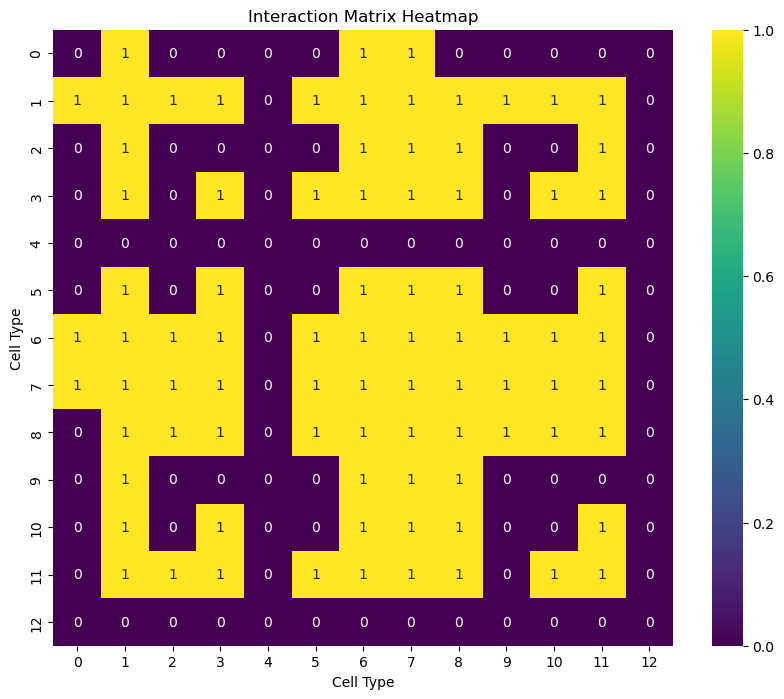

In [33]:
symmetric = ((interaction_matrix + interaction_matrix.T) / 2)
thresholded = symmetric > np.median(symmetric)


plt.figure(figsize=(10, 8))
sns.heatmap(thresholded, annot=True, cmap="viridis", cbar=True)
plt.title("Interaction Matrix Heatmap")
plt.xlabel("Cell Type")
plt.ylabel("Cell Type")
plt.show()

In [34]:
interaction_scores.to_csv(f"data/{LYMPH_NODE_DATASET}/cpdb_scores/interaction_scores.tsv", sep = '\t')
pd.DataFrame(thresholded).to_csv(f"data/{LYMPH_NODE_DATASET}/cpdb_scores/thresholded_interaction_matrix.tsv", sep = '\t')